In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d drgfreeman/rockpaperscissors

 98% 300M/306M [00:04<00:00, 86.9MB/s]
100% 306M/306M [00:04<00:00, 71.2MB/s]


In [ ]:
!unzip "/content/rockpaperscissors.zip" -d "/content/dataset"

Archive:  /content/rockpaperscissors.zip
  inflating: /content/dataset/README_rpc-cv-images.txt  
  inflating: /content/dataset/paper/04l5I8TqdzF9WDMJ.png  
  inflating: /content/dataset/paper/0Og76sl5CJhbxWWx.png  
  inflating: /content/dataset/paper/0RA9rcrv8iVvuDDU.png  
  inflating: /content/dataset/paper/0Uomd0HvOB33m47I.png  
  inflating: /content/dataset/paper/0a3UtNzl5Ll3sq8K.png  
  inflating: /content/dataset/paper/0cb6cVL8pkfi4wF6.png  
  inflating: /content/dataset/paper/0eqArS2GgsBeqgSn.png  
  inflating: /content/dataset/paper/0t08v9bAaA0mXGCQ.png  
  inflating: /content/dataset/paper/0vugygEjxQJPr9yz.png  
  inflating: /content/dataset/paper/0zKU6wEhT2cDe9j0.png  
  inflating: /content/dataset/paper/14K62H4KG1hg5qiJ.png  
  inflating: /content/dataset/paper/1Dfw5FRlS4h60JPX.png  
  inflating: /content/dataset/paper/1Frbe8cdOdkciOBg.png  
  inflating: /content/dataset/paper/1Tt9U9SzrOm98Xtw.png  
  inflating: /content/dataset/paper/1fKclJk4eBWOQSR1.png  
  inflating: /con

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
datasaet_path = "dataset/"

CONFIG = {
    "IM_SIZE" : 256,
    "BATCH_SIZE" : 32,
}

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datasaet_path,
    image_size = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size = CONFIG["BATCH_SIZE"],
    seed = 123,
    shuffle = True,
    subset = "training",
    validation_split = 0.2,
)

Found 2188 files belonging to 4 classes.
Using 1751 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datasaet_path,
    image_size = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size = CONFIG["BATCH_SIZE"],
    seed = 123,
    shuffle = True,
    subset = "validation",
    validation_split = 0.2,
)

Found 2188 files belonging to 4 classes.
Using 437 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['.ipynb_checkpoints', 'paper', 'rock', 'scissors']


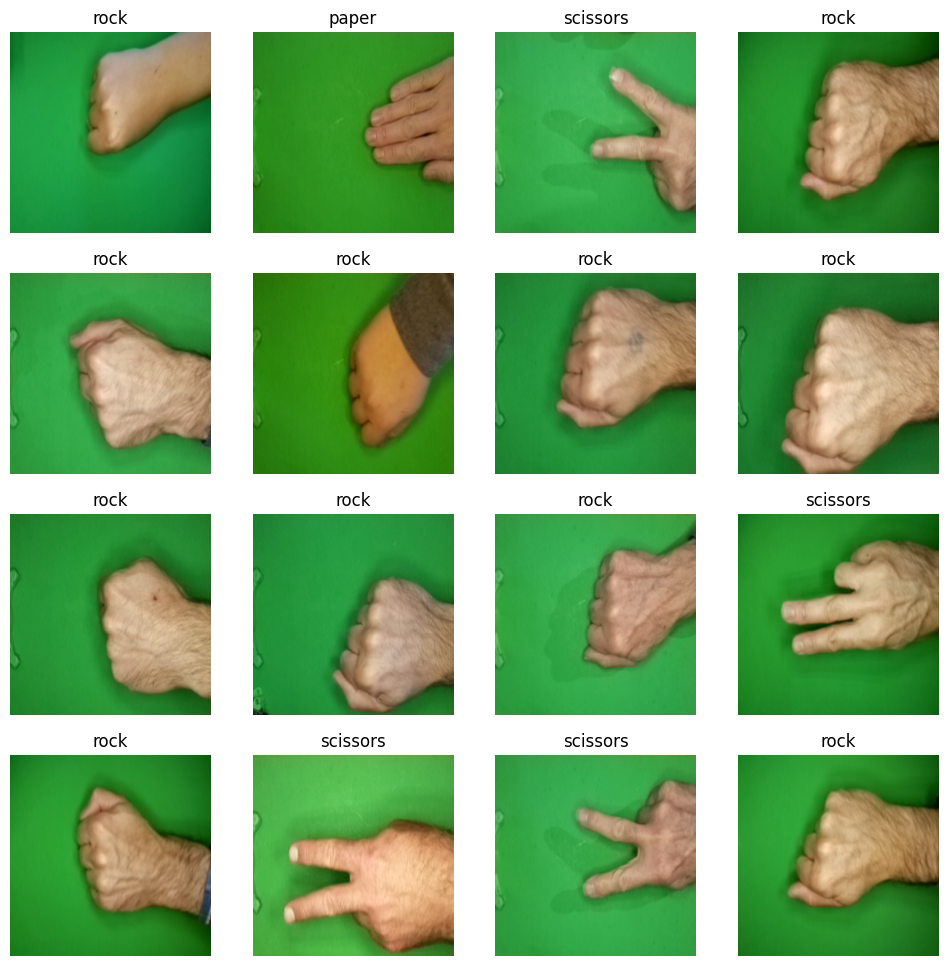

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    plt.title(class_names[labels[i].numpy()])
    plt.axis("off")

In [ ]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

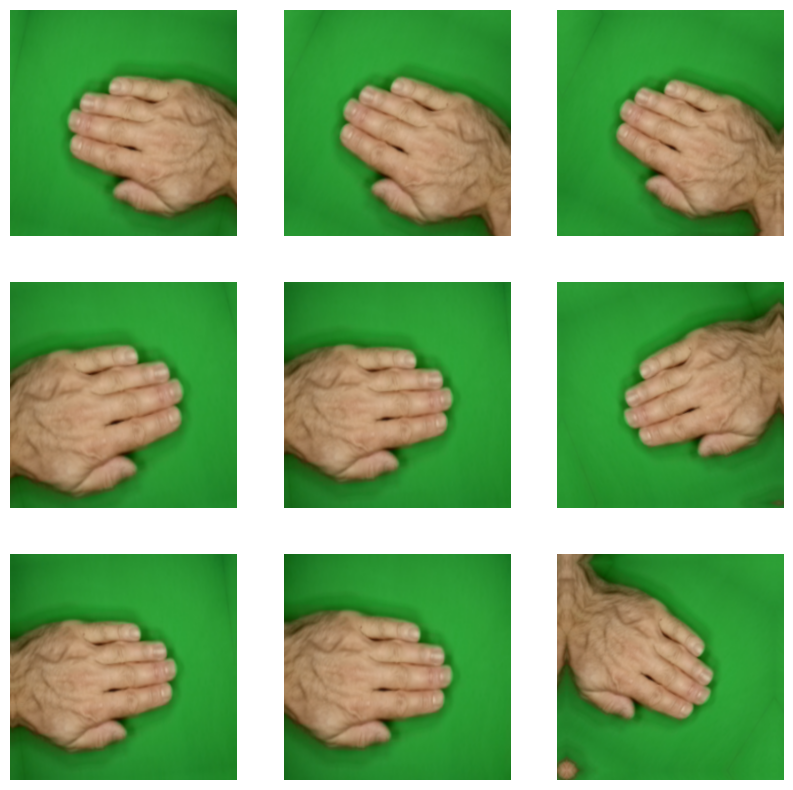

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
print(f"Train Size: {len(train_ds)} Val Size: {len(val_ds)}")
print(train_ds)
print(val_ds)

Train Size: 55 Val Size: 14
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255,input_shape = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),

    data_augmentation,

    tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,strides = 1, padding = "valid",activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,strides = 1, padding = "valid",activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(filters = 128, kernel_size = 3,strides = 1, padding = "valid",activation="relu"),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512,activation = "relu"),
    tf.keras.layers.Dense(128,activation = "relu"),

    tf.keras.layers.Dense(len(class_names),activation = "softmax"),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [ ]:
history = model.fit(train_ds,validation_data = val_ds,epochs = 10, batch_size= CONFIG["BATCH_SIZE"])

Epoch 1/10
55/55 [==============================] - 27s 164ms/step - loss: 1.2895 - accuracy: 0.4809 - val_loss: 0.7997 - val_accuracy: 0.7529
Epoch 2/10
55/55 [==============================] - 12s 136ms/step - loss: 0.6382 - accuracy: 0.7567 - val_loss: 0.3917 - val_accuracy: 0.8146
Epoch 3/10
55/55 [==============================] - 12s 139ms/step - loss: 0.3286 - accuracy: 0.8955 - val_loss: 0.1352 - val_accuracy: 0.9588
Epoch 4/10
55/55 [==============================] - 11s 136ms/step - loss: 0.1973 - accuracy: 0.9355 - val_loss: 0.1114 - val_accuracy: 0.9703
Epoch 5/10
55/55 [==============================] - 11s 136ms/step - loss: 0.1516 - accuracy: 0.9475 - val_loss: 0.1096 - val_accuracy: 0.9657
Epoch 6/10
55/55 [==============================] - 11s 139ms/step - loss: 0.1289 - accuracy: 0.9560 - val_loss: 0.0833 - val_accuracy: 0.9817
Epoch 7/10
55/55 [==============================] - 12s 162ms/step - loss: 0.1051 - accuracy: 0.9686 - val_loss: 0.0865 - val_accuracy: 0.9817

In [ ]:
model.evaluate(val_ds)

14/14 [==============================] - 2s 89ms/step - loss: 0.1388 - accuracy: 0.9611


[0.1388004571199417, 0.9610983729362488]

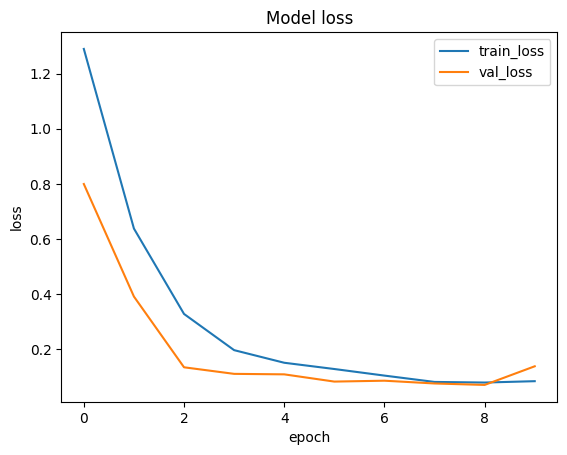

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train_loss","val_loss"])
plt.show()

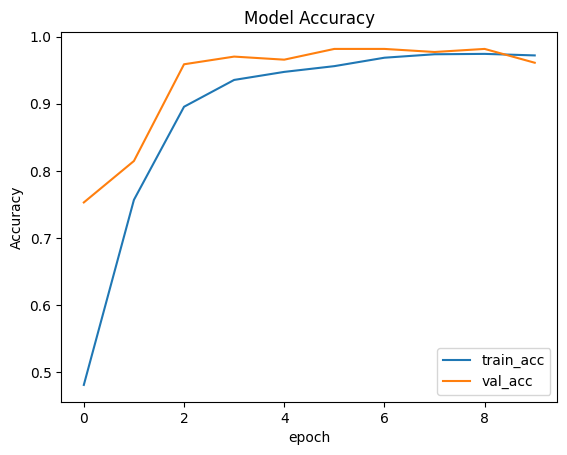

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(["train_acc","val_acc"])
plt.show()

1/1 [==============================] - 0s 23ms/step


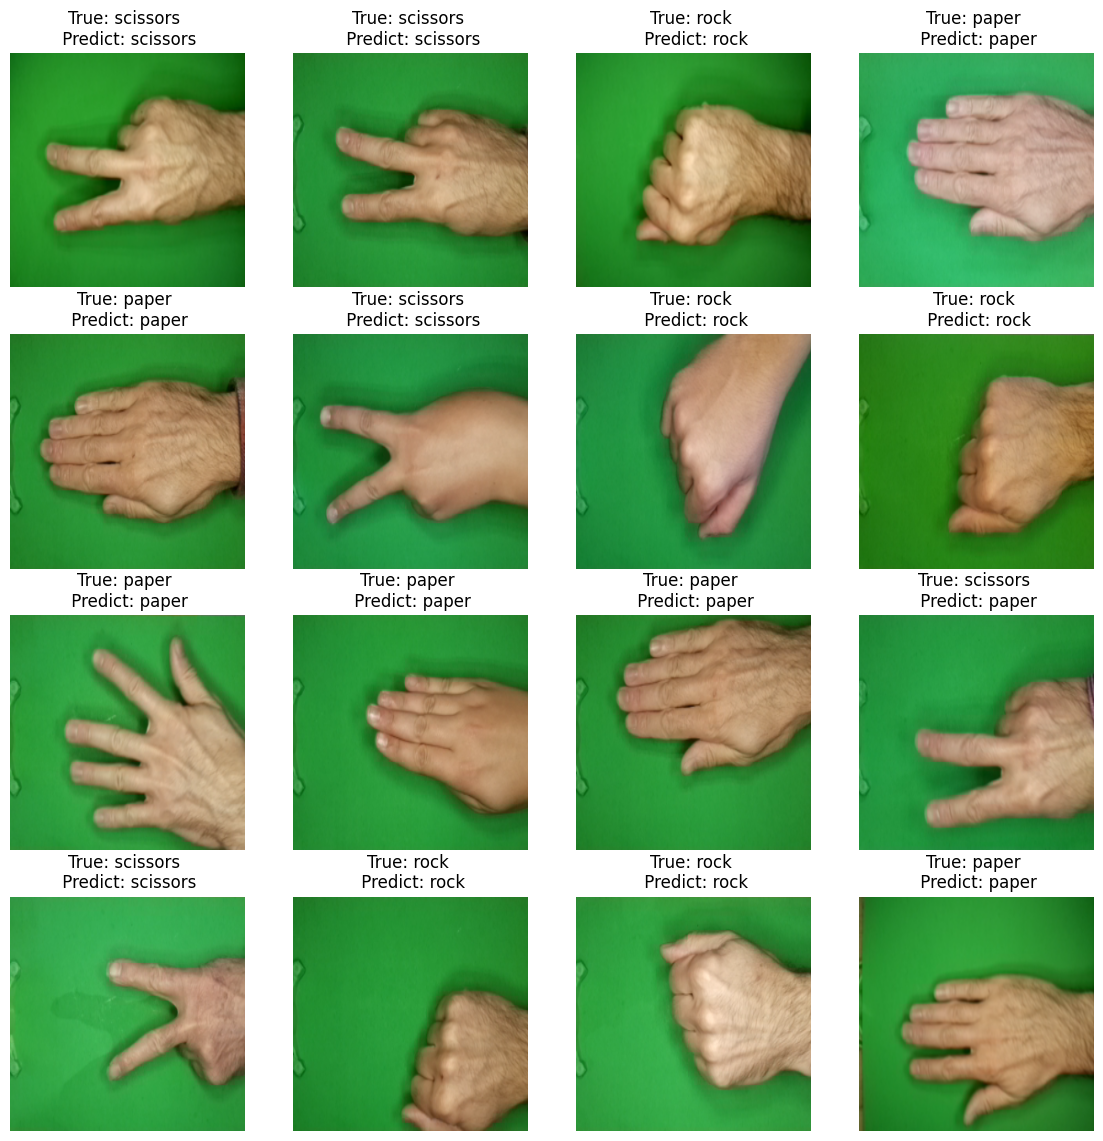

In [ ]:
plt.figure(figsize = (14,14))

for images,labels in val_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    true_label = class_names[labels[i].numpy()]
    img_pred = tf.expand_dims(images[i],axis = 0)
    prediction = class_names[np.argmax(model.predict(img_pred))]
    plt.title(f"True: {true_label} \n Predict: {prediction}")
    plt.axis("off")